# GeoPandas demo



In [1]:
%matplotlib inline

import pandas as pd

import geopandas
from shapely.geometry import Point, Polygon

## Read and write GIS file formats

GeoPandas can read and write many different GIS file formats by relying on the `fiona` library (which is an interface to GDAL/OGR).

For example, let's start by reading a GeoJSON file about the administrative districts in Paris (https://opendata.paris.fr/explore/dataset/quartier_paris/) and some real-time information about the public bicycle sharing system in Paris (vélib, https://opendata.paris.fr/explore/dataset/stations-velib-disponibilites-en-temps-reel/information/):

In [2]:
stations = geopandas.read_file("stations-velib-disponibilites-en-temps-reel.geojson").to_crs("EPSG:2154")

In [3]:
stations[['status', 'name', 'bike_stands', 'available_bikes', 'geometry']].head()

,status,name,bike_stands,available_bikes,geometry
0,OPEN,14002 - RASPAIL QUINET,44,4,POINT (650791.111 6860114.328)
1,OPEN,20503 - COURS DE VINCENNES PYRÉNÉES,21,3,POINT (656402.183 6861017.443)
2,OPEN,20011 - PYRÉNÉES-DAGORNO,21,0,POINT (656354.481 6861882.518)
3,CLOSED,31008 - VINCENNES (MONTREUIL),56,0,POINT (658718.855 6862109.911)
4,OPEN,43006 - MINIMES (VINCENNES),28,27,POINT (658223.433 6860310.369)


In [4]:
quartiers = geopandas.read_file("quartier_paris.geojson").to_crs("EPSG:2154")

In [5]:
quartiers.head()

,n_sq_qu,perimetre,objectid,longueur,c_qu,surface,n_sq_ar,c_quinsee,l_qu,c_ar,geometry
0,750000047,6155.005036,29,6154.591387,47,1.902932e+06,750000012,7511203,Bercy,12,"POLYGON ((655300.043 6858622.629, 655234.899 6..."
1,750000001,5057.549475,41,5057.332772,1,8.690007e+05,750000001,7510101,St-Germain-l'Auxerrois,1,"POLYGON ((651908.563 6861756.318, 651908.510 6..."
2,750000076,4435.273252,79,4435.143641,76,1.294988e+06,750000019,7511904,Combat,19,"POLYGON ((655141.552 6864679.034, 655225.818 6..."
3,750000065,5264.597082,68,5264.463406,65,1.465071e+06,750000017,7511701,Ternes,17,"POLYGON ((648292.159 6863981.309, 648292.157 6..."
4,750000010,2139.625388,50,2139.535591,10,2.717503e+05,750000003,7510302,Enfants-Rouges,3,"POLYGON ((653566.835 6862585.416, 653578.250 6..."


## What's a GeoDataFrame and GeoSeries?

- `GeoDataFrame` is a DataFrame which has a 'geometry' column. The `.geometry` attribute returns a GeoSeries (the column name itself is not necessarily 'geometry')
- `GeoSeries` is a Series that holds (shapely) geometry objects (Points, LineStrings, Polygons, ...)

In [6]:
type(stations)

geopandas.geodataframe.GeoDataFrame

In [7]:
stations.geometry

0       POINT (650791.111 6860114.328)
1       POINT (656402.183 6861017.443)
2       POINT (656354.481 6861882.518)
3       POINT (658718.855 6862109.911)
4       POINT (658223.433 6860310.369)
                     ...              
1221    POINT (654687.766 6860712.833)
1222    POINT (652740.926 6858078.793)
1223    POINT (650946.443 6862308.489)
1224    POINT (647035.627 6858843.236)
1225    POINT (650500.802 6863128.734)
Name: geometry, Length: 1226, dtype: geometry

In [8]:
type(stations.geometry)

geopandas.geoseries.GeoSeries

In [9]:
type(stations.geometry[0])

shapely.geometry.point.Point

## It's still a DataFrame

We still have our pandas functionality that we can use on the geospatial dataset (e.g. boolean filtering).

In [10]:
stations = stations[stations['status'] == 'OPEN'].copy()

A histogram showing the distribution of the number of bike stands in the stations:

In [11]:
stations["bike_stands"].mean()

32.5539629005059

<AxesSubplot:>

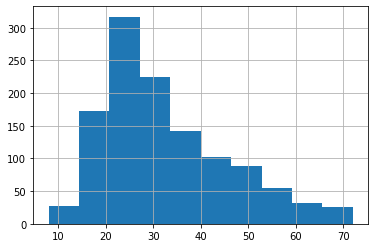

In [12]:
stations['bike_stands'].hist()

## But now has access to spatial predicates and operations

For example, we can access the area of the different quartiers:

In [13]:
quartiers.geometry.area

0     1.902932e+06
1     8.690007e+05
2     1.294988e+06
3     1.465071e+06
4     2.717503e+05
          ...     
75    2.822799e+05
76    1.073734e+06
77    1.381893e+06
78    7.965891e+05
79    7.607266e+05
Length: 80, dtype: float64

Or calculate the distance from a certain point to all the bike stations.

I used `geopy` to localize the Notre Dame:

```python
>>> from geopy.geocoders import Nominatim
>>> geolocator = Nominatim()
>>> location = geolocator.geocode("Notre Dame Paris")
>>> notre_dame = Point(location.longitude, location.latitude)
>>> print(notre_dame)
POINT (2.35005149954546 48.85293695)
>>> print(geopandas.GeoSeries([Point(2.35005149954546, 48.85293695)], crs="EPSG:4326").to_crs("EPSG:2154").item())
POINT (652308.0319198373 6861629.256416338)
```

In [14]:
notre_dame = Point(652308, 6861629)

In [15]:
stations.distance(notre_dame)

0       2143.638041
1       4139.605642
2       4054.414548
4       6060.621679
5       6480.059796
           ...     
1221    2550.029500
1222    3576.506228
1223    1521.690270
1224    5963.086187
1225    2348.438661
Length: 1186, dtype: float64

Or check in which quartier the Notre Dame is located:

In [16]:
quartiers.contains(notre_dame)

0     False
1     False
2     False
3     False
4     False
      ...  
75    False
76    False
77    False
78    False
79    False
Length: 80, dtype: bool

In [17]:
quartiers[quartiers.contains(notre_dame)]

,n_sq_qu,perimetre,objectid,longueur,c_qu,surface,n_sq_ar,c_quinsee,l_qu,c_ar,geometry
5,750000016,3283.163371,56,3282.999717,16,378252.153674,750000004,7510404,Notre-Dame,4,"POLYGON ((653130.494 6861138.094, 653144.937 6..."


Many spatial predicates and operations:

- Predicates: contains, covers, crosses, intersects, equals, overlaps, touches, within
- Operations: difference, intersection, union, buffer, distance, length, area, interpolate, project, relate, 


## Visualize your geospatial data

GeoPandas allows you to quickly visualize your geometries:

<AxesSubplot:>

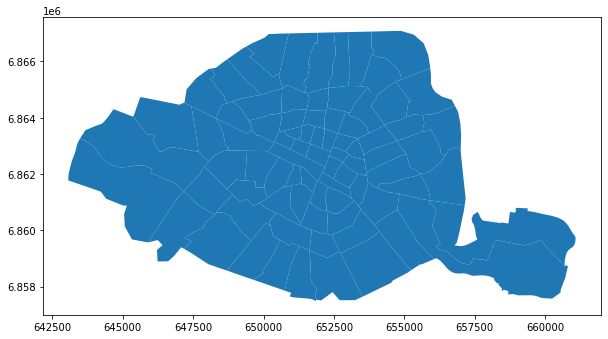

In [18]:
quartiers.plot(figsize=(10, 10))

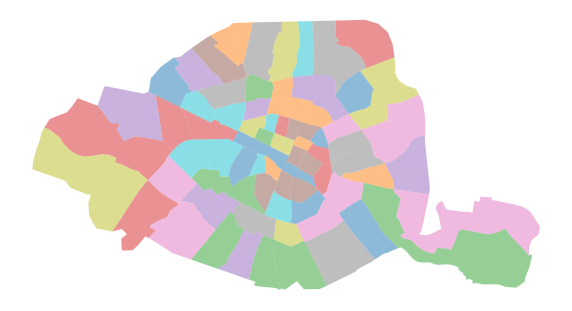

In [19]:
ax = quartiers.plot(figsize=(10, 10), cmap='tab10', alpha=0.5)
ax.set_axis_off()

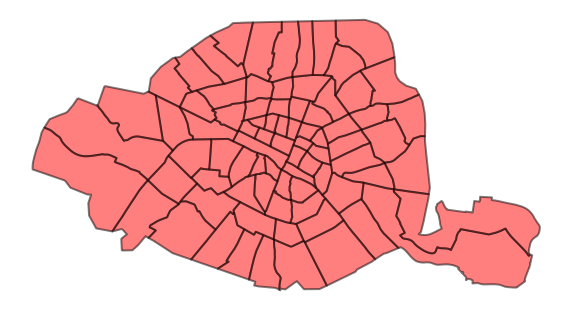

In [20]:
ax = quartiers.plot(figsize=(10, 10), edgecolor='k',
                    facecolor='r', alpha=0.5, linewidth=2)
ax.set_axis_off()

<AxesSubplot:>

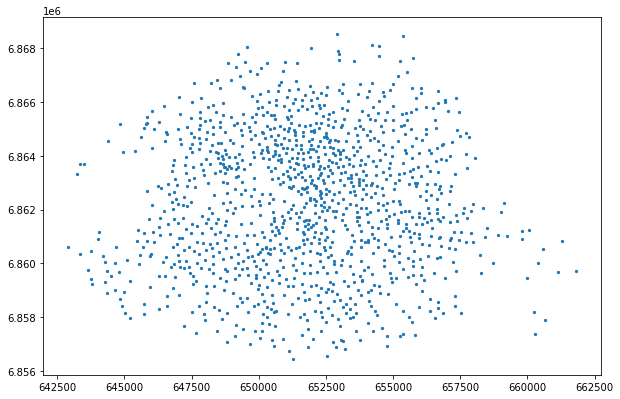

In [21]:
stations.plot(markersize=5, figsize=(10, 10))

Get some more context for a matplotlib based plot using contextily:

In [22]:
import contextily

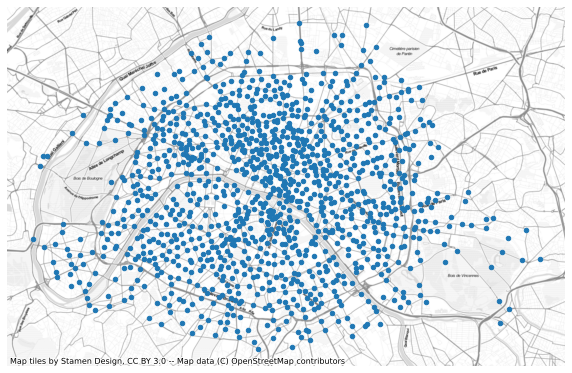

In [23]:
ax = stations.to_crs(3857).plot(markersize=20, figsize=(10, 10))
contextily.add_basemap(ax, source=contextily.providers.Stamen.TonerLite)
ax.set_axis_off()

Or use the `explore()` method using Folium / Leaflet.js under the hood:

In [24]:
stations[["geometry"]].explore()

### Color the plot based on values

By specifying the `column` keyword, we can color the geometries based on the values of that column:

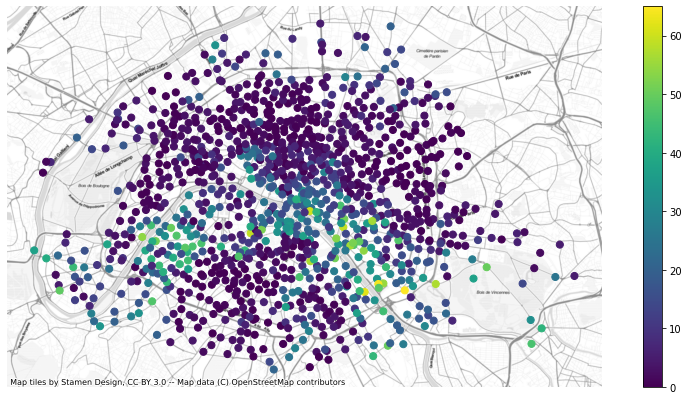

In [25]:
ax = stations.plot(column='available_bikes',
                   markersize=50, legend=True, figsize=(15, 7))
contextily.add_basemap(ax, source=contextily.providers.Stamen.TonerLite, crs=stations.crs)
ax.set_axis_off()

Or based on categorical values:

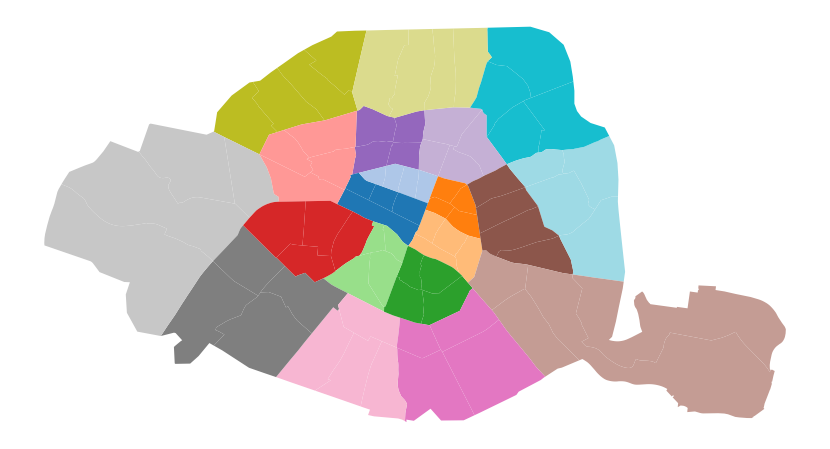

In [26]:
ax = quartiers.plot(column='n_sq_ar', categorical=True,
                    cmap='tab20', figsize=(15, 8))
ax.set_axis_off()

## Spatial joins

GeoPandas includes functionality to perform spatial joins and overlays (`sjoin` and `overlay`).

Here, let's do a spatial join to determine the quartier in which each bike station is located.

In [27]:
stations2 = geopandas.sjoin(stations,
                           quartiers[['l_qu', 'geometry']].copy(),
                           predicate='within')

In [28]:
counts = stations2.groupby('l_qu').size()

In [29]:
quartiers = geopandas.GeoDataFrame(quartiers.merge(counts.reset_index(name='number_bike_stations')))

In [30]:
quartiers.head()

,n_sq_qu,perimetre,objectid,longueur,c_qu,surface,n_sq_ar,c_quinsee,l_qu,c_ar,geometry,number_bike_stations
0,750000047,6155.005036,29,6154.591387,47,1.902932e+06,750000012,7511203,Bercy,12,"POLYGON ((655300.043 6858622.629, 655234.899 6...",9
1,750000001,5057.549475,41,5057.332772,1,8.690007e+05,750000001,7510101,St-Germain-l'Auxerrois,1,"POLYGON ((651908.563 6861756.318, 651908.510 6...",4
2,750000076,4435.273252,79,4435.143641,76,1.294988e+06,750000019,7511904,Combat,19,"POLYGON ((655141.552 6864679.034, 655225.818 6...",13
3,750000065,5264.597082,68,5264.463406,65,1.465071e+06,750000017,7511701,Ternes,17,"POLYGON ((648292.159 6863981.309, 648292.157 6...",18
4,750000010,2139.625388,50,2139.535591,10,2.717503e+05,750000003,7510302,Enfants-Rouges,3,"POLYGON ((653566.835 6862585.416, 653578.250 6...",3


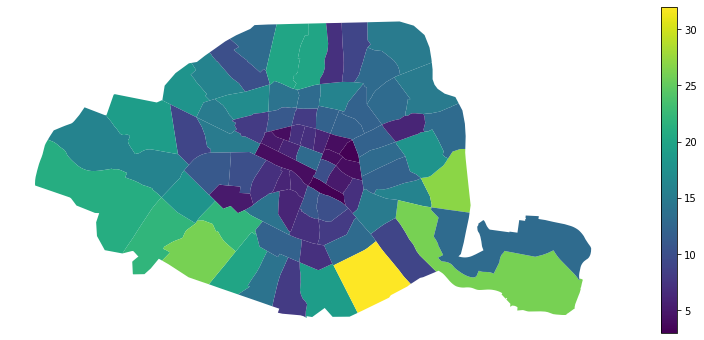

In [31]:
ax = quartiers.plot(column='number_bike_stations', figsize=(15, 6),
                    legend=True)
ax.set_axis_off()

In [32]:
quartiers['number_bike_stations_relative'] = (
    quartiers['number_bike_stations'] / quartiers.geometry.area)

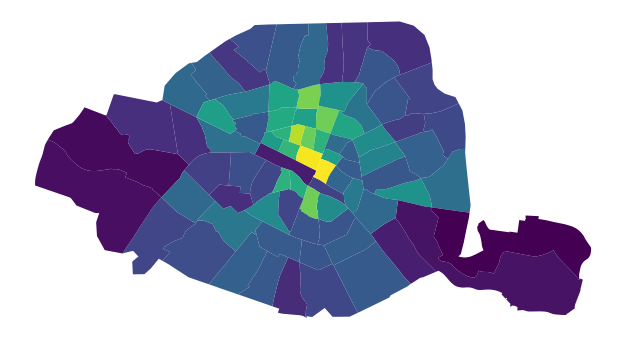

In [33]:
ax = quartiers.plot(column='number_bike_stations_relative',
                    figsize=(15, 6))
ax.set_axis_off()

## Coordinate reference systems

In [34]:
stations = geopandas.read_file("stations-velib-disponibilites-en-temps-reel.geojson")

A GeoDataFrame or GeoSeries has a `.crs` attribute which holds (optionally) a description of the coordinate reference system of the geometries:

In [35]:
stations.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [36]:
stations.geometry.head(3)

0    POINT (2.32956 48.83920)
1    POINT (2.40591 48.84772)
2    POINT (2.40517 48.85550)
Name: geometry, dtype: geometry

We can convert this to another reference system using the `to_crs` function. 
For example, let's convert it to the UTM 31U zone reference system (http://epsg.io/32631) which unit is metres.

In [37]:
stations2 = stations.to_crs(epsg=32631)
# or 
# stations.to_crs("+proj=utm +zone=31 +ellps=WGS84 +datum=WGS84 +units=m +no_defs ")

In [38]:
stations2.geometry.head(3)

0    POINT (450804.449 5409797.268)
1    POINT (456414.352 5410698.461)
2    POINT (456366.909 5411563.320)
Name: geometry, dtype: geometry

In [39]:
quartiers = geopandas.read_file("quartier_paris.geojson")

In [40]:
quartiers2 = quartiers.to_crs(epsg=32631)

In [41]:
(quartiers2.geometry.area / 1000**2)

0     1.901972
1     0.868538
2     1.294254
3     1.464259
4     0.271603
        ...   
75    0.282132
76    1.073169
77    1.381170
78    0.796153
79    0.760312
Length: 80, dtype: float64

In [ ]:
import folium

In [ ]:
m = folium.Map([48.8566, 2.3429], zoom_start=12, tiles="OpenStreetMap")
m.choropleth(geo_str=quartiers.to_json(), data=quartiers, columns=['objectid', 'number_bike_stations_relative'],
             key_on='feature.properties.objectid', fill_color='BuGn', highlight=True)

In [ ]:
m

Urban Atlas is providing pan-European comparable land use and land cover data for Large Urban Zones (http://www.eea.europa.eu/data-and-maps/data/urban-atlas)

The data file for Paris is rather big, so I cutted a subset for the center of Paris and saved that again as a shapefile:

```python
urban_atlas_full = geopandas.read_file('/fr001l_paris', vfs='zip:///.../fr001l_paris.zip')
x, y = 3760000, 2890000
us_subset = urban_atlas_full.cx[x-8000 : x+8000, y-8000 : y+8000].copy()
area = Polygon([(x-8000, y-8000), (x+8000, y-8000), (x+8000, y+8000), (x-8000, y+8000)])
us_subset['geometry'] = us_subset.geometry.intersection(area)
us_subset.to_file("fr001l_paris.shp")
```

In [ ]:
us = geopandas.read_file("fr001l_paris.shp")

In [ ]:
us.head()

In [ ]:
us.crs

In [ ]:
ax = us.plot(figsize=(20,20))
ax.set_axis_off()

In [ ]:
ax = us.plot(column='ITEM', figsize=(20,20), legend=True, cmap='tab20')
ax.set_axis_off()

In [ ]:
pd.options.display.max_rows = 60

In [ ]:
us.ITEM.value_counts()

In [ ]:
us.groupby('ITEM')['geometry'].agg(lambda x: x.area.sum()).sort_values(ascending=False)

In [ ]:
us[us.ITEM == 'Green urban areas'].geometry.area.hist(bins=np.arange(0, 1000000, 50000))